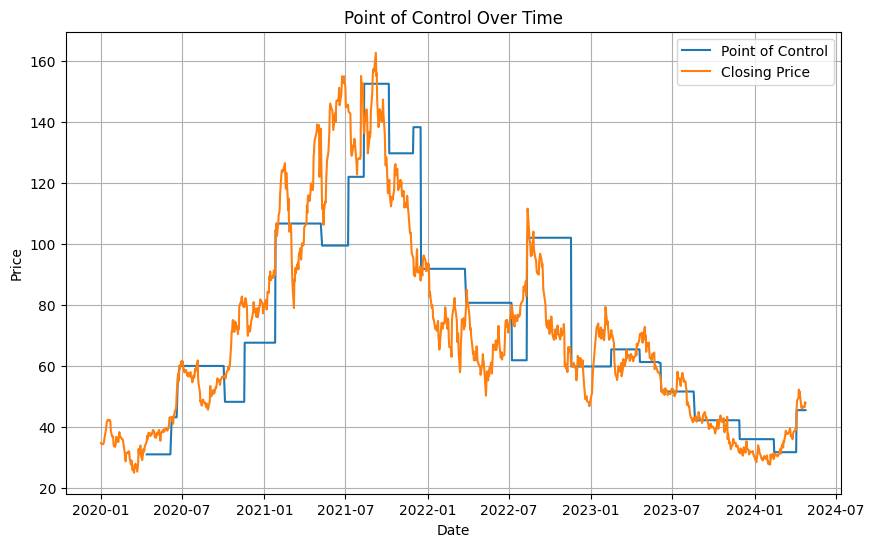

In [282]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

def load_random_file(data_directory):
    try:
        files = [file for file in os.listdir(data_directory) if file.endswith('.csv')]
        file_path = os.path.join(data_directory, np.random.choice(files))
        return pd.read_csv(file_path), file_path
    except Exception as e:
        print(f"Failed to load file: {e}")
        return None, None

def calculate_poc_rolling(data, window_size=70):
    # Initialize an empty list to store the PoC for each window
    poc_values = []
    dates = []

    # Loop over the DataFrame with a rolling window
    for i in range(len(data) - window_size + 1):
        window = data.iloc[i:i + window_size]
        # Calculate the volume at each price level within the window
        volume_by_price = window.groupby('Close')['Volume'].sum()
        # Find the price level with the maximum volume (PoC)
        poc = volume_by_price.idxmax()
        poc_values.append(poc)
        dates.append(window['Date'].iloc[-1])

    return pd.DataFrame({'Date': dates, 'PoC': poc_values})

# Example usage
data_directory = 'Data/PriceData'
df, file_path = load_random_file(data_directory)
if df is not None:
    df['Date'] = pd.to_datetime(df['Date'])  # Ensure Date column is datetime type
    poc_df = calculate_poc_rolling(df)
    
    # Plotting the Point of Control over time
    plt.figure(figsize=(10, 6))
    plt.plot(poc_df['Date'], poc_df['PoC'], label='Point of Control')
    ##also plot the closing price
    plt.plot(df['Date'], df['Close'], label='Closing Price')
    plt.title('Point of Control Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Failed to load data.")


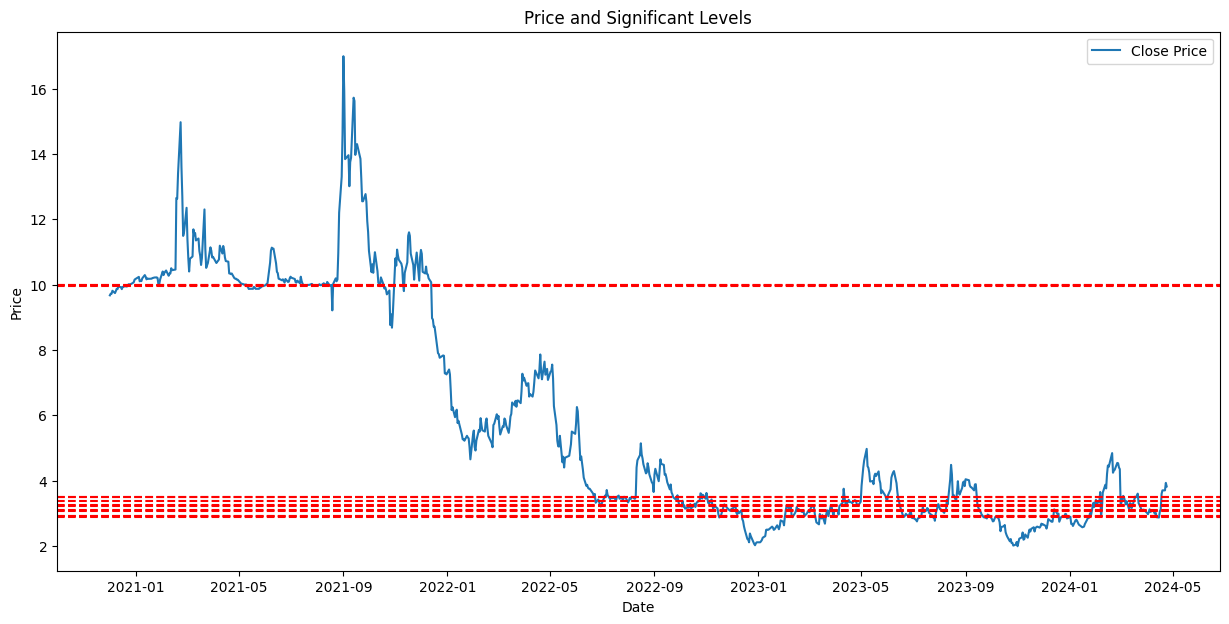

In [416]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def find_price_frequencies(df, window_size=282):
    """Calculate price frequency within a rolling window."""
    price_freq = df['Close'].rolling(window=window_size).apply(lambda x: pd.Series(x).value_counts().idxmax())
    return price_freq




def plot_price_levels(df, levels):
    """Plot the price levels with zones."""
    plt.figure(figsize=(15, 7))
    plt.plot(df['Date'], df['Close'], label='Close Price')
    for level in levels:
        plt.axhline(y=level, color='r', linestyle='--')
    plt.title('Price and Significant Levels')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()





# Example usage
data_directory = 'Data/PriceData'
df, file_path = load_random_file(data_directory)
if df is not None:
    df['Date'] = pd.to_datetime(df['Date'])
    price_levels = find_price_frequencies(df)
    plot_price_levels(df, price_levels.dropna().unique())
else:
    print("Failed to load data.")


[*********************100%%**********************]  1 of 1 completed

ValueError: Accuracy order acc must be positive EVEN integer

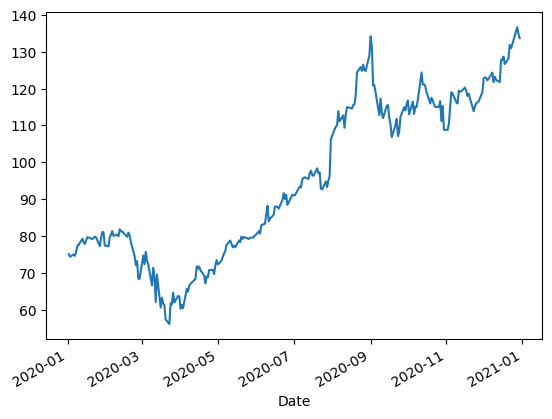

In [421]:
import trendln
import yfinance as yf

# Fetch historical data for a stock
hist = yf.download('AAPL', start='2020-01-01', end='2020-12-31')

### Calculate support and resistance trend lines
##mins, maxes = trendln.calc_support_resistance(data['Close'])
##hlines = trendln.get_extrema_points(data['Close'])
##
### Plot the results
##fig = trendln.plot_support_resistance(data['Close']) # This is an example
##fig.show()

df.Close.plot()
h = df.Close
mins, maxs = trendln.calc_support_resistance(h)
minimaIdxs, pmin, mintrend, minwindows = trendln.calc_support_resistance((hist[-1000:].Low, None)) #support only
mins, maxs = trendln.calc_support_resistance((hist[-1000:].Low, hist[-1000:].High))
(minimaIdxs, pmin, mintrend, minwindows), (maximaIdxs, pmax, maxtrend, maxwindows) = mins, maxs
